Text(0.5, 1.0, 'KMeans Clustering of Blobs')

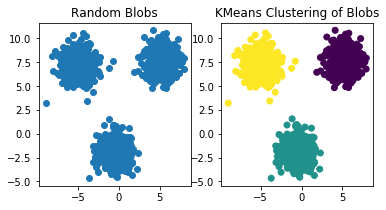

In [3]:
# start of my code
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
n_samples = 1500
random_state = 10701
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
plt.figure(figsize=(6,3))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1])
plt.title('Random Blobs')

y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("KMeans Clustering of Blobs")

Text(0.5, 1.0, 'Non-Centroid Blobs GMM')

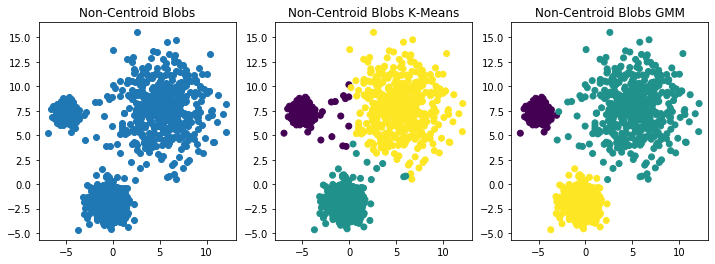

In [2]:
X_noncentroid, y_noncentroid = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_noncentroid)
y_pred_GMM = GaussianMixture(n_components=3).fit_predict(X_noncentroid)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(X_noncentroid[:, 0], X_noncentroid[:, 1])
plt.title("Non-Centroid Blobs")
plt.subplot(132)
plt.scatter(X_noncentroid[:, 0], X_noncentroid[:, 1], c=y_pred)
plt.title("Non-Centroid Blobs K-Means")
plt.subplot(133)
plt.scatter(X_noncentroid[:, 0], X_noncentroid[:, 1], c=y_pred_GMM)
plt.title("Non-Centroid Blobs GMM")

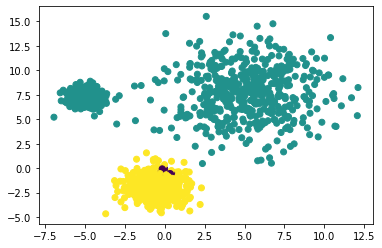

In [29]:
from scipy import stats
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn
#gmm based on  https://towardsdatascience.com/gaussian-mixture-modelling-gmm-833c88587c7f 
def initialize_params(X,components=3):
    kmeans = KMeans(n_clusters= components)
    fitted = kmeans.fit(X)
    prediction = kmeans.predict(X)
    d = X.shape[1]
    labels = np.unique(prediction)
    pi = np.zeros(components)
    mu = np.zeros((components, d))
    sigma = np.zeros((components, d, d))

    for i, label in enumerate(labels):
        idx = np.where(prediction == label) 
        pi[i] = len(idx[0]) / X.shape[0]
        mu[i,:] = np.mean(X[idx], axis = 0)
        muDiff = X[idx] - mu[i,:]
        Nk = X[idx].shape[0]
        sigma[i,:, :] = np.dot(pi[i] * muDiff.T, muDiff) / Nk
        pi[i]=1/components
    assert np.sum(pi) == 1    
    return (pi,mu,sigma)

def e_step(x, pi,mu,sigma,components=3):
    r = np.zeros((len(x), components))
    for k in range(components):
        r[:,k] = pi[k]*mvn.pdf(x, mu[k], sigma[k])
    for k in range(components):   
        r[:,k] /= sum([pi[j]*mvn.pdf(x, mu[j], sigma[j]) for j in range(components)])
    N = np.sum(r, axis=0)
    return r,N
    

def m_step(x,r,N,components=3):
    new_mu = np.dot(r.T, X) / np.sum(r, axis = 0)[:,np.newaxis]
    new_sigma = np.zeros((components,x.shape[1],x.shape[1]))
    for c in range(components):
        x = X - new_mu[c, :] 
        
        diag = np.diag(r[:,c])
        x_mu = np.matrix(x)
        diag = np.matrix(diag)

        sigma_c = x.T * diag * x
        a = (sigma_c) / np.sum(r, axis = 0)[:,np.newaxis][c]
        new_sigma[c,:,:]=a
    new_pi = np.mean(r,axis=0)
    return (new_pi,new_mu,new_sigma)

def predict(x,pi,mu,sigma,components=3):
    prob = []
    prob.append([pi[k]*mvn.pdf(X, mu[k], sigma[k]) for k in range(components)])
    labels = np.array(prob)

    labels  = labels.argmax(1)
    return labels
def show_EM(x, iters= 1,components=3):
    pi,mu,sigma = initialize_params(X_noncentroid)
    for i in range(iters):
        r,N = e_step(x, pi,mu,sigma)
        pi,mu,sigma = m_step(x,r,N)
    
    pred = predict(x,pi,mu,sigma)    
    plt.scatter(X_noncentroid[:, 0], X_noncentroid[:, 1], c=pred[0])
    return 
show_EM(X_noncentroid,iters=5)